In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.utils import save_model, load_model
from jcopml.plot import plot_missing_value
from jcopml.feature_importance import mean_score_decrease

import matplotlib.pyplot as plt
import seaborn as sns

# Import Datasets

In [2]:
bangalore = pd.read_csv("datasets/Bangalore.csv")
chennai = pd.read_csv("datasets/Chennai.csv")

# gabungkan file tersebut dan namai dengan df
df = pd.concat([bangalore, chennai])

# bikin index ulang.
df = df.reset_index()

# hapus colom index lama.
df.drop(columns="index", inplace=True)

# tampilkan 5 data
df.head()

,Price,Area,Location,No. of Bedrooms,Resale,MaintenanceStaff,Gymnasium,SwimmingPool,LandscapedGardens,JoggingTrack,...,LiftAvailable,BED,VaastuCompliant,Microwave,GolfCourse,TV,DiningTable,Sofa,Wardrobe,Refrigerator
0,30000000,3340,JP Nagar Phase 1,4,0,1,1,1,1,1,...,1,0,0,0,0,0,0,0,0,0
1,7888000,1045,Dasarahalli on Tumkur Road,2,0,0,1,1,1,1,...,1,0,1,0,0,0,0,0,0,0
2,4866000,1179,Kannur on Thanisandra Main Road,2,0,0,1,1,1,1,...,1,0,0,0,0,0,0,0,0,0
3,8358000,1675,Doddanekundi,3,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,6845000,1670,Kengeri,3,0,1,1,1,1,1,...,1,0,0,0,0,0,0,0,0,0


# Cek Data Bolong

In [7]:
df.isna().sum()

Price                  0
Area                   0
Location               0
No. of Bedrooms        0
Resale                 0
MaintenanceStaff       0
Gymnasium              0
SwimmingPool           0
LandscapedGardens      0
JoggingTrack           0
RainWaterHarvesting    0
IndoorGames            0
ShoppingMall           0
Intercom               0
SportsFacility         0
ATM                    0
ClubHouse              0
School                 0
24X7Security           0
PowerBackup            0
CarParking             0
StaffQuarter           0
Cafeteria              0
MultipurposeRoom       0
Hospital               0
WashingMachine         0
Gasconnection          0
AC                     0
Wifi                   0
Children'splayarea     0
LiftAvailable          0
BED                    0
VaastuCompliant        0
Microwave              0
GolfCourse             0
TV                     0
DiningTable            0
Sofa                   0
Wardrobe               0
Refrigerator           0


# Visualize
### Data Target

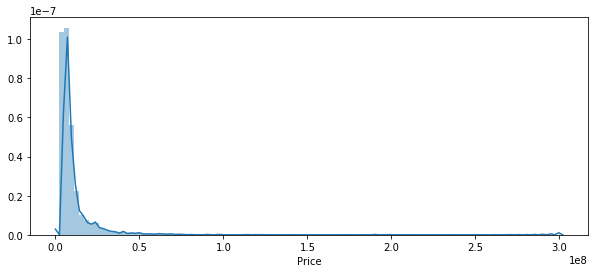

In [13]:
plt.figure(figsize=(10, 4))
ax = sns.distplot(df["Price"], bins=100)
plt.show()

### Data kolom Area

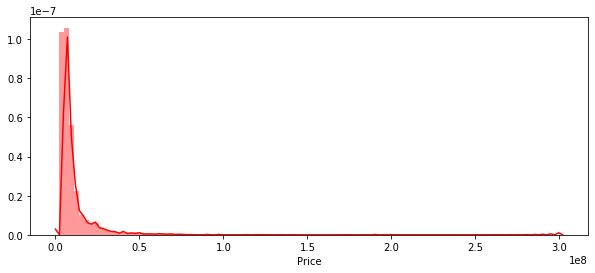

In [14]:
plt.figure(figsize=(10, 4))
ax = sns.distplot(df["Price"], bins=100, color='r')
plt.show()

# Datasets Splitting

In [15]:
X = df.drop(columns="Price")
y = df["Price"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((8976, 39), (2245, 39), (8976,), (2245,))

# Think Simple
### Preprocessor

In [19]:
from xgboost import XGBRegressor

In [21]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(), ["Area", "No. of Bedrooms"]),
    ('categoric', cat_pipe(encoder='onehot'), ["Location",'Resale', 'MaintenanceStaff', 'Gymnasium', 'SwimmingPool',
                                               'LandscapedGardens', 'JoggingTrack', 'RainWaterHarvesting', 'IndoorGames',
                                               'ShoppingMall', 'Intercom', 'SportsFacility', 'ATM', 'ClubHouse', 'School',
                                               '24X7Security', 'PowerBackup', 'CarParking', 'StaffQuarter', 'Cafeteria',
                                               'MultipurposeRoom', 'Hospital', 'WashingMachine', 'Gasconnection', 'AC', 'Wifi',
                                               "Children'splayarea", 'LiftAvailable', 'BED', 'VaastuCompliant', 'Microwave',
                                               'GolfCourse', 'TV', 'DiningTable', 'Sofa', 'Wardrobe', 'Refrigerator']),
])

pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', XGBRegressor(n_jobs=-1, random_state=42))
])

### Training

In [22]:
from sklearn.model_selection import RandomizedSearchCV
from jcopml.tuning import random_search_params as rsp

In [24]:
model = RandomizedSearchCV(pipeline, rsp.xgb_params , cv=3, n_iter=20, n_jobs=-1, verbose=1, random_state=42)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   19.9s finished


[19:12:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
{'algo__colsample_bytree': 0.42066805426927745, 'algo__gamma': 1, 'algo__learning_rate': 0.035015835937029005, 'algo__max_depth': 9, 'algo__n_estimators': 176, 'algo__reg_alpha': 2.772824182801065, 'algo__reg_lambda': 0.0010661259689433889, 'algo__subsample': 0.5553736512887829}
0.5839457101335508 0.30942894271104165 0.3815391360098812


# Feature Importance

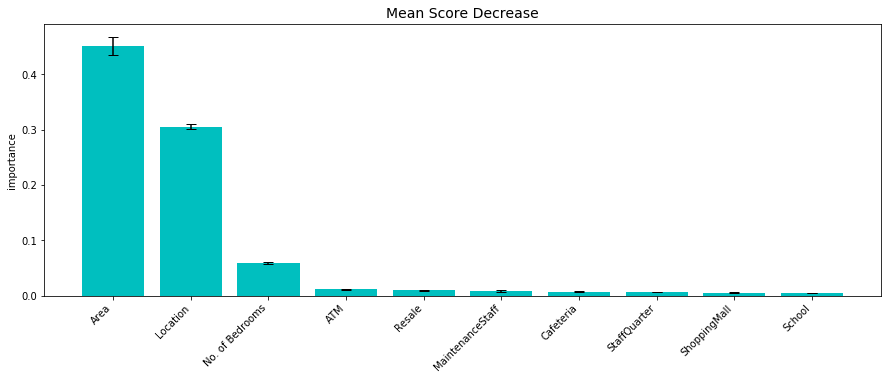

In [25]:
df_imp = mean_score_decrease(X_train, y_train, model, plot=True, topk=10)

# Reduce columns
### Preprocessor - Training

In [26]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(), ["Area", "No. of Bedrooms"]),
    ('categoric', cat_pipe(encoder='onehot'), ["Location",'Resale', 'MaintenanceStaff', 'ATM', 'Cafeteria'])
])

pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', XGBRegressor(n_jobs=-1, random_state=42))
])

model = RandomizedSearchCV(pipeline, rsp.xgb_params , cv=3, n_iter=30, n_jobs=-1, verbose=1, random_state=42)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   13.3s finished


[19:17:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
{'algo__colsample_bytree': 0.2583327274096109, 'algo__gamma': 4, 'algo__learning_rate': 0.02981935017114935, 'algo__max_depth': 5, 'algo__n_estimators': 147, 'algo__reg_alpha': 0.968201208688247, 'algo__reg_lambda': 0.3967633935744863, 'algo__subsample': 0.7246117052470891}
0.4185116573796829 0.326715663736643 0.3675299132526214


# Tuning
### Preprocessor - Training

In [28]:
from jcopml.tuning.space import Integer, Real

In [29]:
parameter_tune = {
    'prep__numeric__poly__degree': Integer(low=1, high=3),
    'prep__numeric__poly__interaction_only': [True, False],
    'algo__max_depth': Integer(low=1, high=10),
    'algo__learning_rate': Real(low=-2, high=0, prior='log-uniform'),
    'algo__n_estimators': Integer(low=100, high=200),
    'algo__subsample': Real(low=0.3, high=0.8, prior='uniform'),
    'algo__gamma': Integer(low=1, high=10),
    'algo__colsample_bytree': Real(low=0.1, high=1, prior='uniform'),
    'algo__reg_alpha': Real(low=-3, high=1, prior='log-uniform'),
    'algo__reg_lambda': Real(low=-3, high=1, prior='log-uniform')
}

In [30]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(poly=2), ["Area", "No. of Bedrooms"]),
    ('categoric', cat_pipe(encoder='onehot'), ["Location",'Resale', 'MaintenanceStaff', 'ATM', 'Cafeteria'])
])

pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', XGBRegressor(n_jobs=-1, random_state=42))
])

model = RandomizedSearchCV(pipeline, parameter_tune , cv=3, n_iter=40, n_jobs=-1, verbose=1, random_state=42)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   18.6s finished


[19:23:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
{'algo__colsample_bytree': 0.2559648880637612, 'algo__gamma': 1, 'algo__learning_rate': 0.07668394719536059, 'algo__max_depth': 6, 'algo__n_estimators': 147, 'algo__reg_alpha': 0.005388451626382902, 'algo__reg_lambda': 5.475906062783612, 'algo__subsample': 0.6191352969216752, 'prep__numeric__poly__degree': 1, 'prep__numeric__poly__interaction_only': True}
0.4362264414114792 0.3365310352927784 0.37849603984967284


# Tuning part 2

In [32]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(poly=2, scaling='minmax', transform='yeo-johnson'), ["Area", "No. of Bedrooms"]),
    ('categoric', cat_pipe(encoder='onehot'), ["Location",'Resale', 'MaintenanceStaff', 'ATM', 'Cafeteria'])
])

pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', XGBRegressor(n_jobs=-1, random_state=42))
])

parameter_tune = {
    'prep__numeric__poly__degree': Integer(low=1, high=3),
    'prep__numeric__poly__interaction_only': [True, False],
    'algo__max_depth': Integer(low=1, high=10),
    'algo__learning_rate': Real(low=-2, high=0, prior='log-uniform'),
    'algo__n_estimators': Integer(low=100, high=200),
    'algo__subsample': Real(low=0.3, high=0.8, prior='uniform'),
    'algo__gamma': Integer(low=1, high=10),
    'algo__colsample_bytree': Real(low=0.1, high=1, prior='uniform'),
    'algo__reg_alpha': Real(low=-3, high=1, prior='log-uniform'),
    'algo__reg_lambda': Real(low=-3, high=1, prior='log-uniform')
}

model = RandomizedSearchCV(pipeline, parameter_tune , cv=3, n_iter=40, n_jobs=-1, verbose=1, random_state=42)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

C:\Users\ROG\anaconda3\lib\site-packages\jcopml\pipeline\_pipeline.py:65: UserWarning: Transformer has default standardization, so the scaling argument is neglected
  warn("Transformer has default standardization, so the scaling argument is neglected")


Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   17.2s finished
C:\Users\ROG\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:2982: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


[19:27:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
{'algo__colsample_bytree': 0.2559648880637612, 'algo__gamma': 1, 'algo__learning_rate': 0.07668394719536059, 'algo__max_depth': 6, 'algo__n_estimators': 147, 'algo__reg_alpha': 0.005388451626382902, 'algo__reg_lambda': 5.475906062783612, 'algo__subsample': 0.6191352969216752, 'prep__numeric__poly__degree': 1, 'prep__numeric__poly__interaction_only': True}
0.4362291730763335 0.3158327664478045 0.37849390247293124


# Tuning part 3
Preprocessor - Training

In [40]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(poly=2, scaling='minmax', transform='yeo-johnson'), ["Area", "No. of Bedrooms"]),
    ('categoric', cat_pipe(encoder='onehot'), ["Location",'Resale', 'MaintenanceStaff', 'ATM', 'Cafeteria'])
])

pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', XGBRegressor(n_jobs=-1, random_state=42))
])

parameter_tune = {
    'prep__numeric__poly__degree': Integer(low=2, high=4),
    'prep__numeric__poly__interaction_only': [True, False],
    'algo__max_depth': Integer(low=100, high=120),
    'algo__learning_rate': Real(low=-, high=0, prior='log-uniform'),
    'algo__n_estimators': Integer(low=5, high=8),
    'algo__subsample': Real(low=0.9, high=1, prior='uniform'),
    'algo__gamma': Integer(low=1, high=2),
    'algo__colsample_bytree': Real(low=0.9, high=1, prior='uniform'),
    'algo__reg_alpha': Real(low=-2, high=1, prior='log-uniform'),
    'algo__reg_lambda': Real(low=-2, high=1, prior='log-uniform')
}

model = RandomizedSearchCV(pipeline, parameter_tune , cv=3, n_iter=60, n_jobs=-1, verbose=1, random_state=42)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

C:\Users\ROG\anaconda3\lib\site-packages\jcopml\pipeline\_pipeline.py:65: UserWarning: Transformer has default standardization, so the scaling argument is neglected
  warn("Transformer has default standardization, so the scaling argument is neglected")


Fitting 3 folds for each of 60 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:   56.6s finished
C:\Users\ROG\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:2982: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


[20:31:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
{'algo__colsample_bytree': 0.9986639578501175, 'algo__gamma': 2, 'algo__learning_rate': 0.5324478086395741, 'algo__max_depth': 119, 'algo__n_estimators': 5, 'algo__reg_alpha': 6.946175184647431, 'algo__reg_lambda': 9.078272014381135, 'algo__subsample': 0.9753378185258942, 'prep__numeric__poly__degree': 7, 'prep__numeric__poly__interaction_only': False}
0.5874707868458735 0.2722053279101025 0.33950110625958796
